In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import RobustScaler
from keras.models import load_model
from joblib import dump, load

In [21]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU usage


Num GPUs Available:  1
GPU memory growth enabled


In [22]:

split = 0.85
sequence_length = 60
epochs = 50
learning_rate = 0.0001

In [23]:
def load_data1():
    stock_data = pd.read_csv("tempFinetune.csv", delimiter=",")
    # stock_data = pd.read_csv("test.csv", delimiter=";")


    # Convert the 'Date' column to datetime format
    # stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y.%m.%d %H:%M')

    # Sort the data by date (if not already sorted)
    # stock_data = stock_data.sort_values(by='Date')

    # Extract only the 'Close' column
    close_prices = stock_data['close'].values.reshape(-1, 1) 
    # close_prices = stock_data['Close'].values.reshape(-1, 1)  # Reshape to 2D array for scaling
     # Reshape to 2D array for scaling
    # print(close_prices)

    # Split the data into training and testing sets
    # train = close_prices[:train_examples]
    # test = close_prices[train_examples:]

    # len_train = len(train)
    # len_test = len(test)

    # Scale the data
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # train_scaled = scaler.fit_transform(train)
    # test_scaled = scaler.transform(test)


    # Save the scaler
    # dump(scaler, 'scaler.joblib')
    scaler = load('scaler.joblib')
    test_scaled = scaler.transform(close_prices)
    dump(scaler, 'scaler.joblib')
    



    # Define sequence length (same as in the original code)
    # sequence_length = 60  # Example value, adjust as needed

    # Create sequences for training data


    # Create sequences for testing data
    X_test_new = []
    y_test_new = []
    len_test = len(test_scaled)
    print(test_scaled.shape)
    for i in range(len_test - sequence_length):
        X_test_new.append(test_scaled[i:i + sequence_length].flatten())  # Flatten the sequence
        y_test_new.append(test_scaled[i + sequence_length])
    X_test_new = np.array(X_test_new)
    y_test_new = np.array(y_test_new)
    y_test_new_original = scaler.inverse_transform(y_test_new.reshape(-1, 1))
    return X_test_new, y_test_new, y_test_new_original, scaler, close_prices


In [24]:
# model = load_model('model_march_22.h5')
X_test_new, y_test_new, y_test_original, scaler, close_prices = load_data1()
print(X_test_new.shape)
print(y_test_new.shape)
print(y_test_original.shape)
print(close_prices.shape)

(73, 1)
(13, 60)
(13, 1)
(13, 1)
(73, 1)


In [25]:
def calculate_direction_accuracy(actual_values, predicted_values):
    """
    Calculate accuracy of predicted price movement direction
    Returns: accuracy and arrays of actual and predicted directions
    """
    # Calculate actual price movements (1 for up, 0 for down)
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)

    # Calculate predicted price movements (1 for up, 0 for down)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)

    # Calculate accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)

    return direction_accuracy, actual_direction, predicted_direction


In [26]:

def evaluate(predictions):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    # Calculate direction accuracy
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Price predictions
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red",
            linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Direction predictions
    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red",
            linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return mae, mape, (1 - mape), dir_acc

In [27]:
# X_test = X_test_new
# y_test = y_test_new

# model.compile(
#     loss=tf.keras.losses.MeanSquaredError(),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate * 0.1)  # Lower learning rate for fine-tuning
# )
# len_test = len(X_test)
# results = np.zeros((len_test , 1))
# for j in range(len_test):
#         current_input = X_test[j].reshape(1, sequence_length)
#         prediction = model.predict(current_input, verbose=0)
#         results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))
#         # results[j] = np.expm1(prediction.reshape(-1, 1))
#         # results[j] = prediction*1e5
#         # results[j] = scaler.inverse_transform(prediction)
#         # Add new sample to buffer
# #             actual = y_test[j].reshape(1, 1)
# # # Add new data to buffer
# #             if len(data_buffer_X) >= sequence_length:87jhhg
        
# #             # # Append new data
# #             # data_buffer_X.append(current_input)
# #             # data_buffer_y.append(actual)
        
# #             # # Update model if we have at least some minimum data uuhnhlhil[pl;.":"jk j hjb, .m ltt.t.t.t8=
# #             # min_samples_to_train = 10  # You can adjust this value;ml/.;'
# #             # if len(data_buffer_X) >= min_samples_to_train:
# #             #     # Convert buffer to NumPy arrays
# #             #     X_train_new = np.vstack(data_buffer_X)
# #             #     y_train_new = np.vstack(data_buffer_y)
            
# #                 # Update the model with buffered data
# #             model = update_model(model, current_input, actual)


#         if j < len_test  - 1:
#             actual = y_test[j].reshape(1, 1)
#             model.fit(current_input,
#                         actual,
#                         epochs=20,
#                         batch_size = 4048,
#                         verbose=0)
            
# model.save(f'fine_tune_model_march_22.h5')
# model.save(f'fine_tune_model_march_22.keras')

# print(results.shape)
# print(type(results))
# print(y_test.shape)
# print(type(y_test) )

In [28]:
# evaluate(results)

In [29]:
def finetune(X_test, scaler, y_test ):
    total_mae = total_mape = total_acc = total_dir_acc = 0
    model = load_model('fine_tune_model_march_27_2nd_trial.h5')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate * 0.1)  # Lower learning rate for fine-tuning
    )
    len_test = len(X_test)
    results = np.zeros((len_test , 1))
    for j in range(len_test):
            current_input = X_test[j].reshape(1, sequence_length)
            prediction = model.predict(current_input, verbose=0)
            results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))
            # results[j] = np.expm1(prediction.reshape(-1, 1))
            # results[j] = prediction*1e5
            # results[j] = scaler.inverse_transform(prediction)
            # Add new sample to buffer
    #             actual = y_test[j].reshape(1, 1)
    # # Add new data to buffer
    #             if len(data_buffer_X) >= sequence_length:87jhhg
            
    #             # # Append new data
    #             # data_buffer_X.append(current_input)
    #             # data_buffer_y.append(actual)
            
    #             # # Update model if we have at least some minimum data uuhnhlhil[pl;.":"jk j hjb, .m ltt.t.t.t8=
    #             # min_samples_to_train = 10  # You can adjust this value;ml/.;'
    #             # if len(data_buffer_X) >= min_samples_to_train:
    #             #     # Convert buffer to NumPy arrays
    #             #     X_train_new = np.vstack(data_buffer_X)
    #             #     y_train_new = np.vstack(data_buffer_y)
                
    #                 # Update the model with buffered data
    #             model = update_model(model, current_input, actual)


            if j < len_test  - 1:
                actual = y_test[j].reshape(1, 1)
                model.fit(current_input,
                            actual,
                            epochs=20,
                            batch_size = 4048,
                            verbose=0)
                
    model.save(f'fine_tune_model_march_27_2nd_trial.h5')
    model.save(f'fine_tune_model_march_27_2nd_trial.keras')

    print(results.shape)
    print(type(results))
    print(y_test.shape)
    print(type(y_test) )

    mae, mape, acc, dir_acc = evaluate(results)
    
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Price Accuracy: {acc}")
    print(f"Direction Accuracy: {dir_acc}\n")

    return mae, mape, acc, dir_acc, results.tolist(), model

    # return results, model

    # return (total_mae/n), (total_mape/n), (total_acc/n), (total_dir_acc/n), results.tolist(), model


(13, 1)
<class 'numpy.ndarray'>
(13, 1)
<class 'numpy.ndarray'>


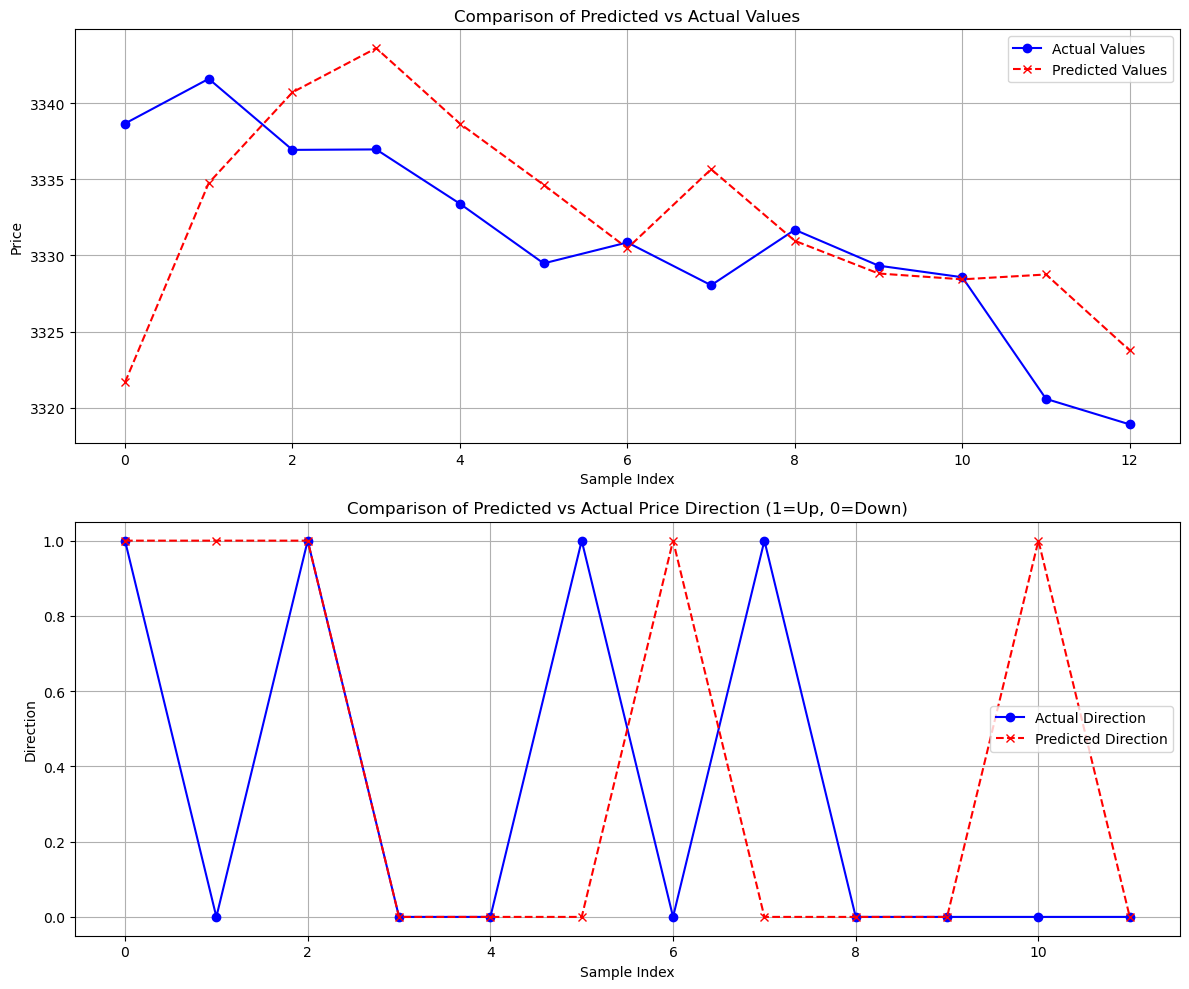

MAE: 5.158399188701913
MAPE: 0.0015479017950757337
Price Accuracy: 0.9984520982049243
Direction Accuracy: 0.5833333333333334



In [30]:
mae , mape, accuracy, dirrection_accuray, predictions, model =finetune(X_test_new, scaler, y_test_new)
# results, model = finetune(X_test_new, scaler, y_test_new)
# finetune(X_test_new, scaler, model, y_test_new)
# mae, mape, acc, dir_acc = evaluate(results)

In [31]:
# newData = pd.read_csv("oneCaseTest.csv", delimiter=",")
# new_test_data_x = newData['close'].values.reshape(-1, 1)
# scaled_new_test_data_x = scaler.transform(new_test_data_x)
# # print(scaled_new_test_data_x)
# # print(scaler.inverse_transform(scaled_new_test_data_x))
# X_test_new_for_one_sample = []

# len_test_one_sample = len(scaled_new_test_data_x)
# print(scaled_new_test_data_x.shape)
# for i in range(len_test_one_sample - sequence_length +1):
#     X_test_new_for_one_sample.append(scaled_new_test_data_x[i:i + sequence_length].flatten()) 
# print(X_test_new_for_one_sample)
# print(X_test_new_for_one_sample[0].shape)
# current_input = X_test_new_for_one_sample[0].reshape(1, sequence_length)
# print(current_input.shape)
# one_sample_prediction = model.predict(current_input, verbose=0)
# print(one_sample_prediction)
# one_sample_prediction = scaler.inverse_transform(one_sample_prediction)
# print(one_sample_prediction)

In [32]:
# unseen_data = pd.read_csv("test_on_unseen_data(18_3-11:30).csv", delimiter=",")
# unseen_close_data = unseen_data['close'].values.reshape(-1, 1)
# scaled_unseen_close_data = scaler.transform(unseen_close_data)


In [33]:
# X_test_new_for_unseen_data = []
# y_test_new_for_unseen_data = []
# len_test_unseen_data = len(scaled_unseen_close_data)
# print(scaled_unseen_close_data.shape)
# for i in range(len_test_unseen_data - sequence_length ):
#     X_test_new_for_unseen_data.append(scaled_unseen_close_data[i:i + sequence_length].flatten())
#     y_test_new_for_unseen_data.append(scaled_unseen_close_data[i + sequence_length])
# len_test_unseen_data = len(X_test_new_for_unseen_data)
# print(len_test_unseen_data)
# print(X_test_new_for_unseen_data[0].shape)
# print(y_test_new_for_unseen_data[0].shape)
# print(len(y_test_new_for_unseen_data))
# results = np.zeros((len_test_unseen_data , 1))


In [34]:
# original_y_test_unseen_data = scaler.inverse_transform(y_test_new_for_unseen_data)
# print(original_y_test_unseen_data)

In [35]:
# current_input = X_test_new_for_unseen_data[0].reshape(1, sequence_length)
# current_input = scaler.inverse_transform(current_input)
# print(current_input.shape)
# print(current_input)
# print(current_input[0][-1])
# real_previous_input = (current_input[0][-1])
# # print(scaler.inverse_transform(real_previous_input))


In [36]:
# direction = []
# for j in range(len_test_unseen_data):
#         current_input = X_test_new_for_unseen_data[j].reshape(1, sequence_length)
#         og_current_input = scaler.inverse_transform(current_input)
#         prediction = model.predict(current_input, verbose=0)
#         results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))
#         real_previous_input = (current_input[0][-1])
        
#         if results[j] > real_previous_input:
#                 direction.append(1)  # Price went up
#         else:
#                 direction.append(0)
#         if j < len_test  - 1:
#                 actual = y_test_new_for_unseen_data[j].reshape(1, 1)
#                 model.fit(current_input,
#                             actual,
#                             epochs=20,
#                             batch_size = 4048,
#                             verbose=0)

# print(results.shape)
# print(results)
# print(direction)

In [37]:
# def calculate_direction_accuracy(actual_values, predicted_values):
#     """
#     Calculate accuracy of predicted price movement direction
#     Returns: accuracy and arrays of actual and predicted directions
#     """
#     # Calculate actual price movements (1 for up, 0 for down)
#     actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)

#     # Calculate predicted price movements (1 for up, 0 for down)
#     predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)

#     # Calculate accuracy
#     direction_accuracy = np.mean(actual_direction == predicted_direction)

#     return direction_accuracy, actual_direction, predicted_direction


In [38]:
# def evalu(predictions, y_test_original):
#     mae = mean_absolute_error(y_test_original, predictions)
#     mape = mean_absolute_percentage_error(y_test_original, predictions)

#     # Calculate direction accuracy
#     dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)
#     print("printing the pred_dir")
#     print(type(pred_dir))
#     print(pred_dir)
    
#     print(f"MAE: {mae}")
#     print(f"MAPE: {mape}")
#     print(f"Price Accuracy: {1 - mape}")
#     print(f"Direction Accuracy: {dir_acc}\n")

#     # Create subplots
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

#     # Plot 1: Price predictions
#     ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
#     ax1.plot(predictions, label="Predicted Values", color="red",
#             linestyle='dashed', marker='x')
#     ax1.set_title("Comparison of Predicted vs Actual Values")
#     ax1.set_xlabel("Sample Index")
#     ax1.set_ylabel("Price")
#     ax1.legend()
#     ax1.grid(True)

#     # Plot 2: Direction predictions
#     ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
#     ax2.plot(pred_dir, label="Predicted Direction", color="red",
#             linestyle='dashed', marker='x')
#     ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
#     ax2.set_xlabel("Sample Index")
#     ax2.set_ylabel("Direction")
#     ax2.legend()
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.show()
    
#     return pred_dir  # Modified return statement


In [39]:
# pred_dir = evalu(results, original_y_test_unseen_data)


In [40]:
print(pred_dir)


NameError: name 'pred_dir' is not defined

In [ ]:
# print(type(pred_dir))
# print(type(results))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# data = pd.read_csv('test_on_unseen_data(18_3-11:30).csv')  # Replace with your actual file name
# time_series = data['datetime'].iloc[60:]  # Get time from line 62 onwards
# print(time_series)

# pred_dir = np.array(pred_dir)
# # pred_dir = np.concatenate(([1], pred_dir))
# # print(pred_dir)
# pred_dir = np.array(pred_dir).flatten()
# results = results.flatten()
# time_series = time_series.reset_index(drop=True)  # Reset index for time series

# # Print original shapes
# print("Original shapes:")
# print("Time series:", time_series.shape)
# print("Pred_dir:", pred_dir.shape)
# print("Results:", results.shape)
# print(time_series[0])
# print(results[0])
# print(pred_dir[0])
# print(original_y_test_unseen_data[0])

# # Create a DataFrame with the results
# df_results = pd.DataFrame({
#     'Time': time_series,
#     'Price': results.flatten(),  # Flatten in case results is 2D
#     'Direction': pred_dir
# })

# # Save to CSV
# df_results.to_csv('predictions_with_direction.csv', index=False)

60     2025-03-18 12:45:00
61     2025-03-18 13:00:00
62     2025-03-18 13:15:00
63     2025-03-18 13:30:00
64     2025-03-18 13:45:00
              ...         
384    2025-03-22 00:45:00
385    2025-03-22 01:00:00
386    2025-03-22 01:15:00
387    2025-03-22 01:30:00
388    2025-03-22 01:45:00
Name: datetime, Length: 329, dtype: object
Original shapes:
Time series: (329,)
Pred_dir: (329,)
Results: (329,)
2025-03-18 12:45:00
3012.821044921875
1
[3015.805]


In [ ]:
# data = pd.read_csv('data_1m.csv')  # Replace with your actual file name
# data = data[['datetime', 'close']]
# print(data)

# # Save to CSV
# # df_results.to_csv('predictions_with_direction.csv', index=False)

                 datetime     close
0     2025-03-18 11:30:00  3008.020
1     2025-03-18 11:31:00  3008.945
2     2025-03-18 11:32:00  3009.995
3     2025-03-18 11:33:00  3010.980
4     2025-03-18 11:34:00  3012.065
...                   ...       ...
4992  2025-03-22 01:42:00  3020.110
4993  2025-03-22 01:43:00  3020.525
4994  2025-03-22 01:44:00  3020.600
4995  2025-03-22 01:45:00  3020.790
4996  2025-03-22 01:46:00  3020.775

[4997 rows x 2 columns]
